In [3]:
# advance neuro project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

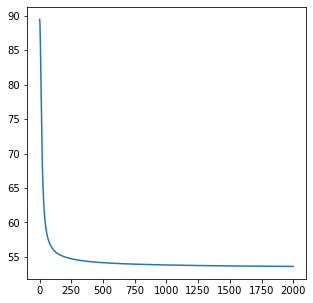

In [45]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))

# here, the network is open loop and the delta2 is created randomly and kept constant during itertions
backward_weight_1 = np.random.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size))

# input layer values
input_layer = np.random.normal(mu, sigma, size=(n_b, input_layer_size)) # initial value of inputs - constant during iterations
error_delta2 = np.random.normal(mu, sigma, size=(n_b, output_layer_size)) # initial value of error_delta 2 - constant during iterations
error_delta1 = np.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
# delta 2 doesn't change

# updating the network parameters
rep = 1
angles1 = np.zeros((rep, number_of_iterations))

for k in range (rep):
    forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
    forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = np.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = np.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*np.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*np.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1

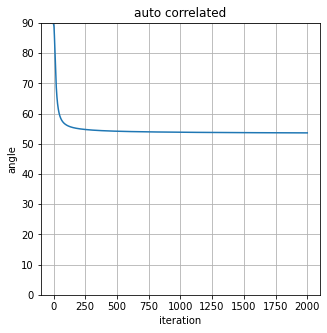

In [52]:
# plot the result of auto correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.squeeze(angles1))
ax.set_ylim([0, 90])
ax.set_title('auto correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)


(60, 2000)


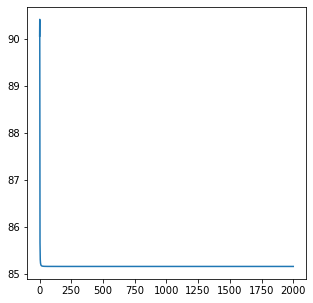

In [13]:
    
fig, ax = plt.subplots(1,1,figsize=(5,5))
print(angles1.shape)
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1,0))
        

In [35]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))

# here, the network is open loop and the delta2 is created randomly and kept constant during itertions
backward_weight_1 = np.random.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size))

input_layer = np.random.normal(mu, sigma, input_layer_size)
input_layer = input_layer.reshape(1,len(input_layer))
error_delta2 = np.random.normal(mu, sigma, output_layer_size) 
error_delta2 = error_delta2.reshape(1,len(error_delta2))
error_delta1 = np.matmul(error_delta2, backward_weight_1)

# updating the network parameters
rep = 1
angles1 = np.zeros((rep, number_of_iterations))

for k in range (rep):
    forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
    forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        delta_w0 = 0
        delta_w1 = 0
        for i in range (n_b):
            # input layer values
            input_layer = np.random.normal(mu, sigma, input_layer_size)
            input_layer = input_layer.reshape(1,len(input_layer))
            error_delta2 = np.random.normal(mu, sigma, output_layer_size) 
            error_delta2 = error_delta2.reshape(1,len(error_delta2))
            error_delta1 = np.matmul(error_delta2, backward_weight_1)
            Z1 = np.matmul(forward_weight_0.T, input_layer.T).T
            hidden_layer_1 = ReLU(Z1)
            delta1 = np.multiply(error_delta1,ReLU_deriv(Z1))
            delta_w0 += LR*np.matmul(input_layer.T, delta1)
            delta2 = error_delta2
            delta_w1 += LR*np.matmul(hidden_layer_1.T, delta2)
            #print(i,j,k,end=" ")
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
    
    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1,0))
        

TypeError: 'axis' is an invalid keyword to ufunc 'fmax'

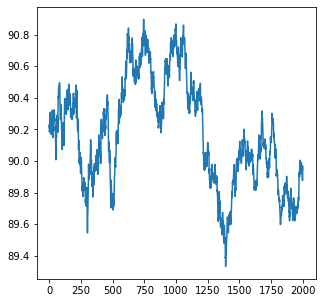

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1,0))

In [37]:
def ReLU(x):
    zeros_mat = np.zeros(x.shape)
    output = np.fmax(x,zeros_mat)
    return output

In [39]:
def ReLU_deriv(x):
    non_negs = np.where(x >= 0)
    output = np.zeros(x.shape)
    output[non_negs] = 1
    return output

In [6]:
def angleCal(A, B):
    num = np.trace(np.matmul(np.conjugate(A.T), B))
    norm_A = math.sqrt(np.trace(np.matmul(A,np.conjugate(A.T))))
    norm_B = math.sqrt(np.trace(np.matmul(B,np.conjugate(B.T))))
    denum = norm_A*norm_B
    angle = np.arccos(num/denum)*180/math.pi
    return angle

In [39]:
### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002

input_layer_size = 20
hidden_layer1_size = 100
hidden_layer2_size = 20

forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,hidden_layer2_size))

# here, the network is open loop and the delta2 is created randomly and kept constant during itertions
backward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer2_size,hidden_layer1_size))

# input layer values

input_layer = np.random.normal(mu, sigma, input_layer_size) # initial value of inputs - constant during iterations
input_layer = input_layer.reshape(1, len(input_layer))
error_delta2 = np.random.normal(mu, sigma, hidden_layer2_size) # initial value of error_delta 2 - constant during iterations
error_delta2 = error_delta2.reshape(1, len(error_delta2))
error_delta1 = np.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
# delta 2 doesn't change

# updating the network parameters
number_of_iterations = 2000
angles1 = np.zeros((number_of_iterations))

for i in range (number_of_iterations):
    hidden_layer_1 = np.matmul(forward_weight_0.T, input_layer.T).T
    delta1 = error_delta1
    forward_weight_0 += LR*np.matmul(input_layer.T,delta1)
    delta2 = error_delta2
    forward_weight_1 += LR*np.matmul(hidden_layer_1.T,delta2)
    angles1[i] = angleCal(forward_weight_1, backward_weight_1.T)
    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),angles1)

(1, 2)
[[1 2]
 [1 2]]
